In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df_spam = pd.read_csv(r'spam.csv')
df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)

df_spam.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_spam['Message'],df_spam['spam'], stratify=df_spam['spam'])

# Build Model

In [8]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [10]:
preprocessed_text = bert_preprocess(['BANANA'])
bert_encoder(preprocessed_text).keys()

dict_keys(['encoder_outputs', 'sequence_output', 'pooled_output', 'default'])

In [17]:
bert_encoder(preprocessed_text)['sequence_output'].shape

TensorShape([1, 128, 768])

In [5]:
# def get_sentence_embeding(sentences):
#     preprocessed_text = bert_preprocess(sentences)
#     return bert_encoder(preprocessed_text)['pooled_output']

In [6]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [7]:
model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

# Training 

In [8]:
history = model.fit(X_train, y_train, epochs=5)

Epoch 1/10
131/131 [==============================] - 765s 6s/step - loss: 0.4103 - accuracy: 0.8660
Epoch 2/10
131/131 [==============================] - 831s 6s/step - loss: 0.3847 - accuracy: 0.8660
Epoch 3/10
131/131 [==============================] - 881s 7s/step - loss: 0.2660 - accuracy: 0.8839
Epoch 4/10
131/131 [==============================] - 709s 5s/step - loss: 0.1628 - accuracy: 0.9517
Epoch 5/10
131/131 [==============================] - 689s 5s/step - loss: 0.1174 - accuracy: 0.9643
Epoch 6/10
131/131 [==============================] - 671s 5s/step - loss: 0.0914 - accuracy: 0.9737
Epoch 7/10
131/131 [==============================] - 671s 5s/step - loss: 0.0834 - accuracy: 0.9761
Epoch 8/10
131/131 [==============================] - 673s 5s/step - loss: 0.0838 - accuracy: 0.9761
Epoch 9/10
131/131 [==============================] - 968s 7s/step - loss: 0.0758 - accuracy: 0.9768
Epoch 10/10
131/131 [==============================] - 1148s 9s/step - loss: 0.0865 - accur

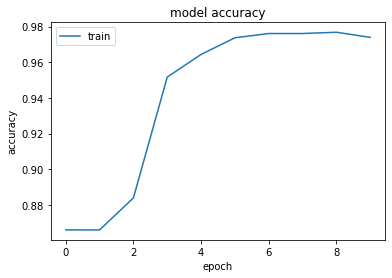

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

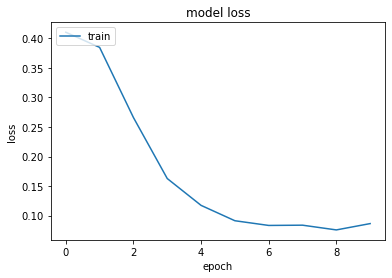

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evalulate

In [11]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 356s 8s/step - loss: 0.0565 - accuracy: 0.9849


[0.056451719254255295, 0.9849246144294739]

# Test

In [12]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.9387248 ],
       [0.941491  ],
       [0.71189296],
       [0.00940557],
       [0.00680486]], dtype=float32)